# Prediction Results with Audio Annotations

**Last Modified**: Jul 29, 2025

In this notebook, we summarize and visualize the results for behavior classification with audio annotations. The training and testing data splits are created randomly for this experiment. We conduct hyperparameter tuning and look at the prediction results f the best performing model.

In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
# System & OS

import sys
import os
import time
import warnings
import random
import psutil
sys.path.append('../')
sys.path.append('../../')

import numpy as np
import pandas as pd
from tqdm import tqdm

# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader

# Script imports
from src.utils.io import (get_results_path,
                          get_metadata_path,
                          get_video_labels_path,
                          get_audio_labels_path,
                            get_figures_dir,
                            get_matched_data_path,
                            get_matched_metadata_path)

from src.utils.plots import(multi_label_predictions)

from config.settings import (RAW_COLLAPSE_BEHAVIORS_MAPPING_W_TROTTING,
                             RAW_COLLAPSE_BEHAVIORS_MAPPING_WO_TROTTING,
                             RAW_BEHAVIORS_WO_TROTTING,
                             RAW_BEHAVIORS_W_TROTTING,
                             SAMPLING_RATE,
                             id_mapping)

from src.utils.data_prep import combined_annotations

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve

device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
device = 'cpu'
a = torch.randn((3, 5))
a.to(device)

tensor([[-0.2744, -0.4058, -0.3775,  0.7016,  0.4949],
        [-0.2905,  0.0195, -1.0718,  1.2400,  0.3773],
        [-0.0564,  1.8182,  1.0221, -1.2535, -0.3821]])

In [20]:
# Graphing Parameters
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams["axes.labelsize"] = 40
mpl.rcParams['legend.fontsize'] = 40
mpl.rcParams['axes.titlesize'] = 45
mpl.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = 'serif'

## 1. Prediction Results without Trotting Behavior

In [14]:
label_encoder = LabelEncoder()
label_encoder.fit(RAW_BEHAVIORS_WO_TROTTING)
experiment_name = 'no_split'

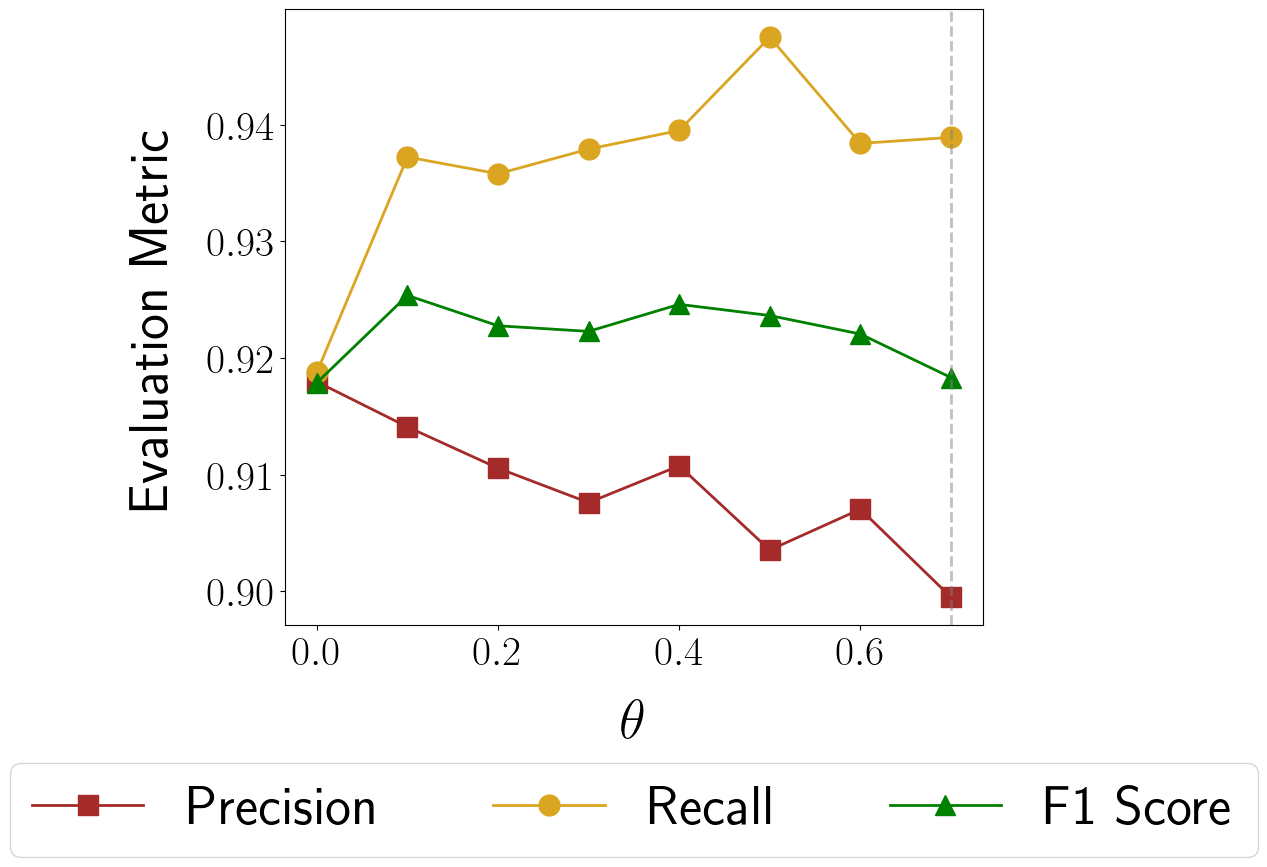

In [5]:
# you need to run 'scrpts/no_split.sh' for produce the hyperparameter finetuning plots.

thetas = 0.1*np.arange(8)
colors = ['brown', 'goldenrod', 'green']

precisions = np.zeros(len(thetas))
recalls = np.zeros(len(thetas))
f1scores = np.zeros(len(thetas))

for i, theta in enumerate(thetas):
    dir = get_results_path('no_split', 3, 64, 5, np.round(theta,1), 50, with_trotting=False)
    precisions[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
    recalls[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
    f1scores[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

plt.figure(figsize=(9,8))
plt.plot(thetas, precisions, color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(thetas, recalls, color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(thetas, f1scores, color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)
plt.axvline(0.7, color='grey', alpha=0.5, linestyle='--')
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)
plt.legend(loc='center', bbox_to_anchor=(.5, -0.3), ncol=3)
# plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

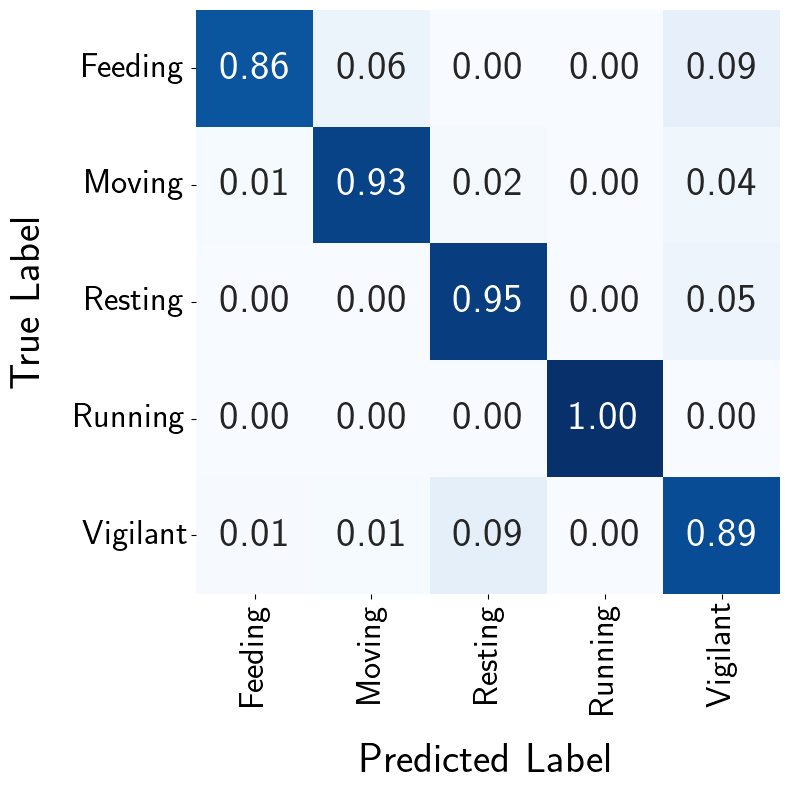

In [6]:
dir = get_results_path('no_split', 3, 64, 5, 0.0, 50, with_trotting=False)
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False)

<Figure size 640x480 with 0 Axes>

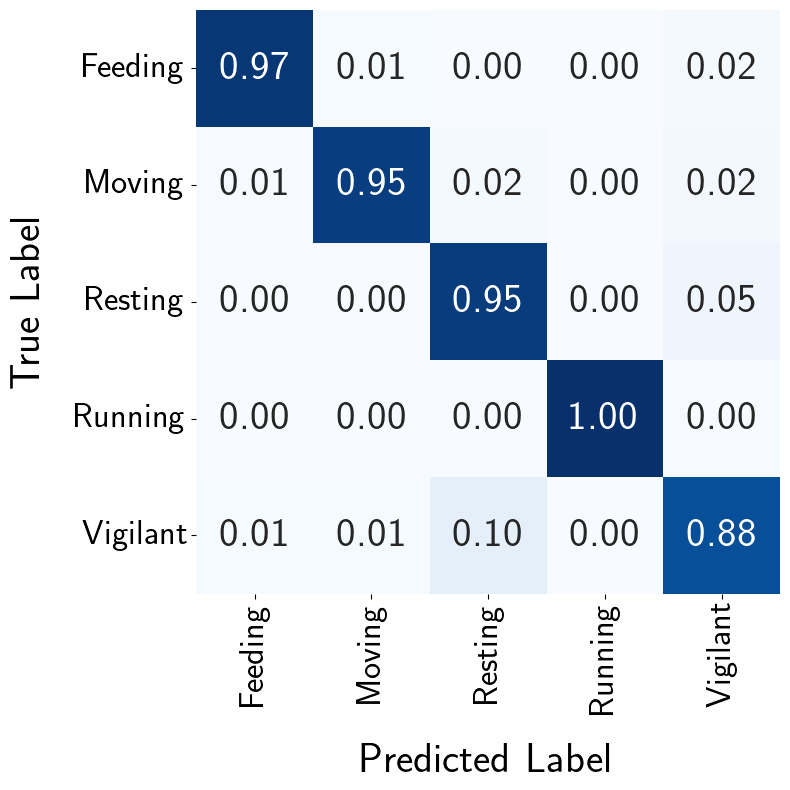

In [7]:
dir = get_results_path('no_split', 3, 64, 5, 0.6, 50, with_trotting=False)
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False)

## 2. Prediction Results with Trotting Behavior

In [15]:
label_encoder = LabelEncoder()
label_encoder.fit(RAW_BEHAVIORS_W_TROTTING)
experiment_name = 'no_split'

In [16]:
RAW_BEHAVIORS_W_TROTTING

['Feeding', 'Moving', 'Resting', 'Running', 'Trotting', 'Vigilant']

In [17]:
# you need to run 'scrpts/no_split.sh' for produce the hyperparameter finetuning plots.

thetas = 0.1*np.arange(11)
colors = ['brown', 'goldenrod', 'green']

precisions = np.zeros(len(thetas))
recalls = np.zeros(len(thetas))
f1scores = np.zeros(len(thetas))

for i, theta in enumerate(thetas):
    dir = get_results_path('no_split', 3, 64, 5, np.round(theta,1), 50, with_trotting=True)
    precisions[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
    recalls[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
    f1scores[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True)


print(precisions)

plt.figure(figsize=(9,8))
plt.plot(thetas, precisions, color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(thetas, recalls, color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(thetas, f1scores, color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)
plt.axvline(0.7, color='grey', alpha=0.5, linestyle='--')
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)
plt.legend(loc='center', bbox_to_anchor=(.5, -0.3), ncol=3)
# plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/medhaaga/BotswanaML/results/predictions/with_trotting/no_split/conv_layers_3/n_channels_64/kernel_size_5/theta_0.0/duration_50/val_true_classes.npy'

<Figure size 640x480 with 0 Axes>

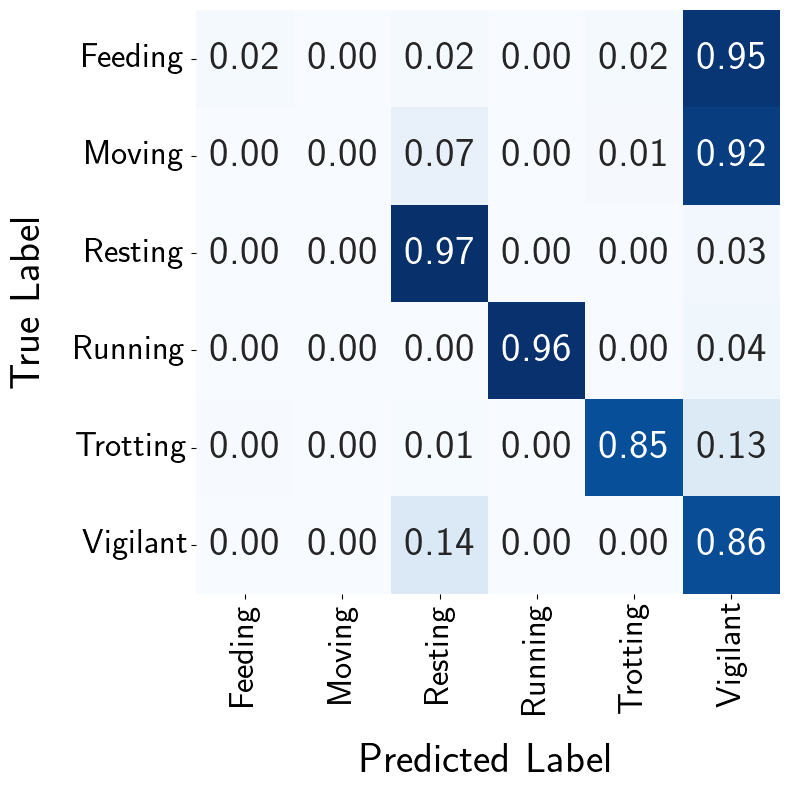

In [19]:
dir = get_results_path('no_split', 3, 64, 5, 0.0, 50, with_trotting=True)
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False)

<Figure size 640x480 with 0 Axes>

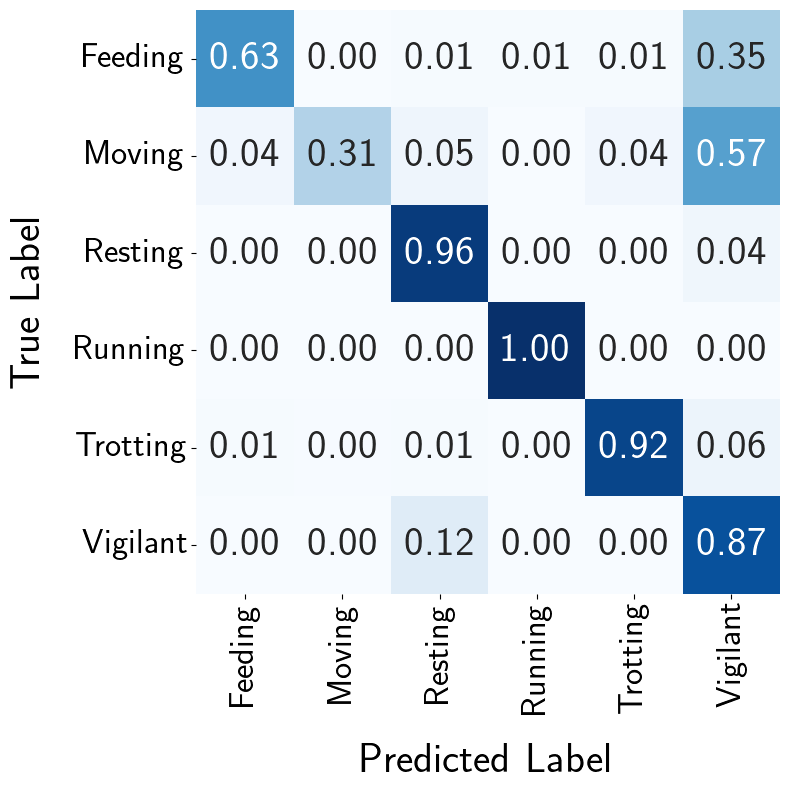

In [33]:
dir = get_results_path('no_split', 3, 64, 5, 0.4, 50, with_trotting=True)
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False)